# Analysis of the Project CSV Data

## Load Data from CSV and Initialize

In [37]:
import json
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

def load_function_data(projects):
    # Add metrics from comment code pair data
    projects['functions'] = -1
    projects['pub_func'] = -1
    projects['func_with_doc'] = -1
    projects['pub_func_with_doc'] = -1
    for index, row in projects.iterrows():
        json_file = 'temp/comment_code_data/{}.json'.format(row['name'])
        try:
            with open(json_file, 'r') as f:
                comment_data = json.load(f)
        except (FileNotFoundError, ValueError):
            pass
        total_methods = 0
        pub_methods = 0
        method_with_doc = 0
        pub_method_with_doc = 0
        for file in comment_data:
            method_info = comment_data[file]['methodInfo']
            total_methods += len(method_info)
            for method in method_info:
                if 'comment' in method:
                    method_with_doc += 1
                if method['visibility'] == 'public':
                    pub_methods += 1
                    if 'comment' in method:
                        pub_method_with_doc += 1
            
        projects.at[index, 'functions'] = total_methods
        projects.at[index, 'pub_func'] = pub_methods
        projects.at[index, 'func_with_doc'] = method_with_doc
        projects.at[index, 'pub_func_with_doc'] = pub_method_with_doc
    

projects = pd.read_csv('result/JavaProjectSample.csv')

# Drop useless rows
del projects['watchers']
del projects['forks']
del projects['src_files']
del projects['']

# Drop data with < 100 of code, and no commits
projects = projects[projects['commits'] > 0]
projects = projects[projects['lines_of_code'] > 100]
projects = projects[projects['src_file_size'] > 0]

projects['comment_density'] = projects['lines_of_comments'] / projects['lines_of_code']
projects['comment_portion'] = projects['comment_size'] / projects['src_file_size']
projects['comments'] = projects['doc_comment'] + projects['impl_comment']
projects['comment_per_file'] = projects['comments'] / projects['src_files']
projects['doc_comment_per_file'] = projects['doc_comment'] / projects['src_files']
projects['impl_comment_per_file'] = projects['impl_comment'] / projects['src_files']
projects['popularity'] = [('High' if x >= 1000 else ('Mid' if x >= 100 else 'Low')) for x in projects['stars']]
  
load_function_data(projects)
    
sns.set(style='white')

projects.describe()

,size,stars,forks,commits,authors,lines_of_code,lines_of_comments,lines_blank,src_files,src_file_size,...,comment_density,comment_portion,comments,comment_per_file,doc_comment_per_file,impl_comment_per_file,functions,pub_func,func_with_doc,pub_func_with_doc
count,8.870000e+02,887.000000,887.000000,887.000000,887.000000,8.870000e+02,8.870000e+02,8.870000e+02,887.000000,8.870000e+02,...,887.000000,887.000000,887.000000,887.000000,887.000000,887.000000,887.000000,887.000000,887.000000,887.000000
mean,7.749039e+04,1598.199549,539.139797,5941.121759,133.555806,1.072550e+05,4.074207e+04,2.178048e+04,1028.649380,6.270337e+06,...,0.324380,0.215971,11600.445321,9.736894,3.109440,6.627454,6630.349493,5058.739572,1412.709132,1002.568207
std,1.791800e+05,4002.397714,1431.237803,21487.526445,242.002138,2.995368e+05,1.805191e+05,6.180781e+04,2735.188603,1.978542e+07,...,0.244137,0.118963,40944.658434,11.938294,3.334604,10.420271,11272.502638,8705.861329,2961.797635,2206.424291
min,4.620000e+02,0.000000,0.000000,502.000000,1.000000,1.020000e+02,4.000000e+00,2.100000e+01,4.000000,2.807000e+03,...,0.000815,0.003124,7.000000,0.121951,0.000000,0.024643,0.000000,0.000000,0.000000,0.000000
25%,5.956000e+03,15.500000,11.000000,920.000000,23.000000,1.178350e+04,2.589000e+03,2.501000e+03,141.500000,6.373885e+05,...,0.164705,0.129808,785.000000,3.998846,1.077835,2.517590,983.500000,732.500000,112.500000,66.500000
50%,2.072600e+04,304.000000,111.000000,1945.000000,62.000000,2.948900e+04,8.057000e+03,6.314000e+03,354.000000,1.633251e+06,...,0.280677,0.213309,2368.000000,6.738908,2.168142,4.326531,2545.000000,1889.000000,361.000000,244.000000
75%,6.833100e+04,1457.000000,455.000000,4741.000000,148.000000,8.319450e+04,2.630500e+04,1.686100e+04,886.500000,4.495258e+06,...,0.435671,0.289864,7319.500000,11.791077,4.033851,7.561177,6483.000000,5001.500000,1221.000000,806.000000
max,2.389684e+06,48989.000000,19706.000000,550545.000000,3972.000000,5.015770e+06,4.358214e+06,1.089598e+06,52755.000000,3.526416e+08,...,3.156340,0.708274,651398.000000,227.800000,38.931818,222.718868,80672.000000,74334.000000,29461.000000,28207.000000


## Utility Functions

In [24]:
def analyze_correlation(x, y, types, ax):
    type_set = set(types)
    corr = {}
    corr['Overall'] = np.corrcoef(x, y)[0][1]
    for t in type_set:
        x1 = [val for idx, val in x.items() if types[idx] == t]
        y1 = [val for idx, val in y.items() if types[idx] == t]
        corr[t] = np.corrcoef(x1, y1)[0][1]
    sns.scatterplot(x, y, hue=types, ax=ax)
    print(corr)

def ranksum_test(x, y, types):
    samples = {}
    pvalues = {}
    means = {}
    for t in types:
        pvalues[t] = {}
        means[t] = {}
        samples[t] = 0
    for s in samples:
        samples[s] = projects[projects[y] == s][x]
        means[s]['Mean'] = np.mean(samples[s])
    for t1 in types:
        for t2 in types:
            statistics, pvalue = stats.ranksums(samples[t1], samples[t2])
            pvalues[t1][t2] = pvalues[t2][t1] = pvalue
    print('Rank-sum Test of {} and {}:'.format(x, y))
    print(pd.DataFrame.from_dict(means))
    print(pd.DataFrame.from_dict(pvalues))

## Comment Density Analysis

In [12]:
ranksum_test('comment_density', 'popularity', ['High', 'Mid', 'Low'])

Rank-sum Test of comment_density and popularity:
          High       Mid       Low
Mean  0.357406  0.310191  0.305141
          High       Mid       Low
High  1.000000  0.008773  0.000053
Mid   0.008773  1.000000  0.133803
Low   0.000053  0.133803  1.000000


In [13]:
ranksum_test('comment_portion', 'popularity', ['High', 'Mid', 'Low'])

Rank-sum Test of comment_portion and popularity:
          High       Mid       Low
Mean  0.238253  0.214058  0.195304
              High       Mid           Low
High  1.000000e+00  0.013575  5.700494e-07
Mid   1.357496e-02  1.000000  1.275431e-02
Low   5.700494e-07  0.012754  1.000000e+00


In [14]:
ranksum_test('doc_comment_per_file', 'popularity', ['High', 'Mid', 'Low'])

Rank-sum Test of doc_comment_per_file and popularity:
          High       Mid      Low
Mean  3.440332  3.037292  2.84644
          High       Mid       Low
High  1.000000  0.001411  0.000018
Mid   0.001411  1.000000  0.248800
Low   0.000018  0.248800  1.000000


In [15]:
ranksum_test('impl_comment_per_file', 'popularity', ['High', 'Mid', 'Low'])

Rank-sum Test of impl_comment_per_file and popularity:
          High      Mid       Low
Mean  6.612128  6.57921  6.691397
          High       Mid       Low
High  1.000000  0.193165  0.001512
Mid   0.193165  1.000000  0.059792
Low   0.001512  0.059792  1.000000


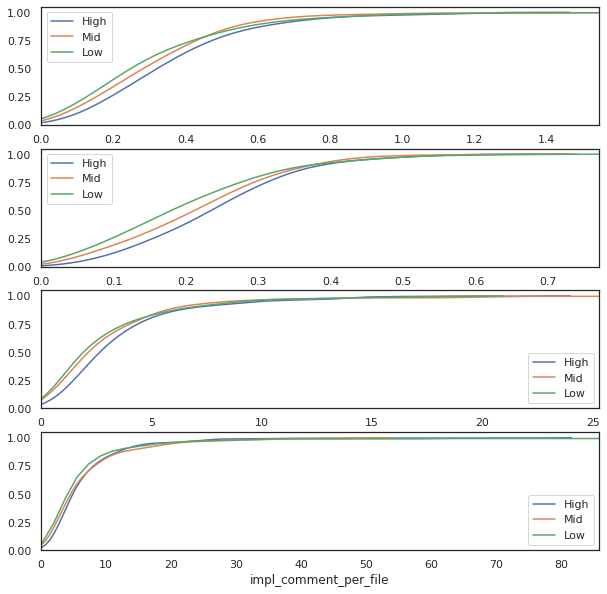

In [16]:
dims = ['comment_density', 'comment_portion', 'doc_comment_per_file', 'impl_comment_per_file']
fig, axes = plt.subplots(len(dims), 1)
fig.set_size_inches(10, 10)
for i, d in enumerate(dims):
    labels = ['High', 'Mid', 'Low']
    for label in labels:
        data = projects[projects['popularity'] == label][d]
        sns.distplot(data, hist=False, label=label, ax=axes[i], kde_kws=dict(cumulative=True))
        axes[i].set_xlim(left=0)

('lines_of_code', 'lines_of_comments'): {'Overall': 0.8777442899959237, 'Mid': 0.8780042731671406, 'Low': 0.84504661752268, 'High': 0.908898984092056}
('lines_of_code', 'comment_density'): {'Overall': 0.08617332092051083, 'Mid': 0.09472853783554683, 'Low': 0.03010219515073991, 'High': 0.09460419256897357}
('stars', 'comment_density'): {'Overall': 0.08890610836480158, 'Mid': 0.056365958336402906, 'Low': -0.03962070805463398, 'High': -0.03553625037511356}
('commits', 'comment_density'): {'Overall': 0.09073242424934382, 'Mid': 0.06624369987825729, 'Low': 0.058770985732442556, 'High': 0.07326601043189311}
('size', 'comment_density'): {'Overall': 0.02161970311006696, 'Mid': 0.019909198757700225, 'Low': -0.06123148652934012, 'High': 0.08806978192491596}
('authors', 'comment_density'): {'Overall': 0.12552750073431698, 'Mid': 0.024588885022507292, 'Low': 0.11850363405130238, 'High': 0.07648716963147856}
('forks', 'comment_density'): {'Overall': 0.11618821564899597, 'Mid': 0.12039243838316563, 

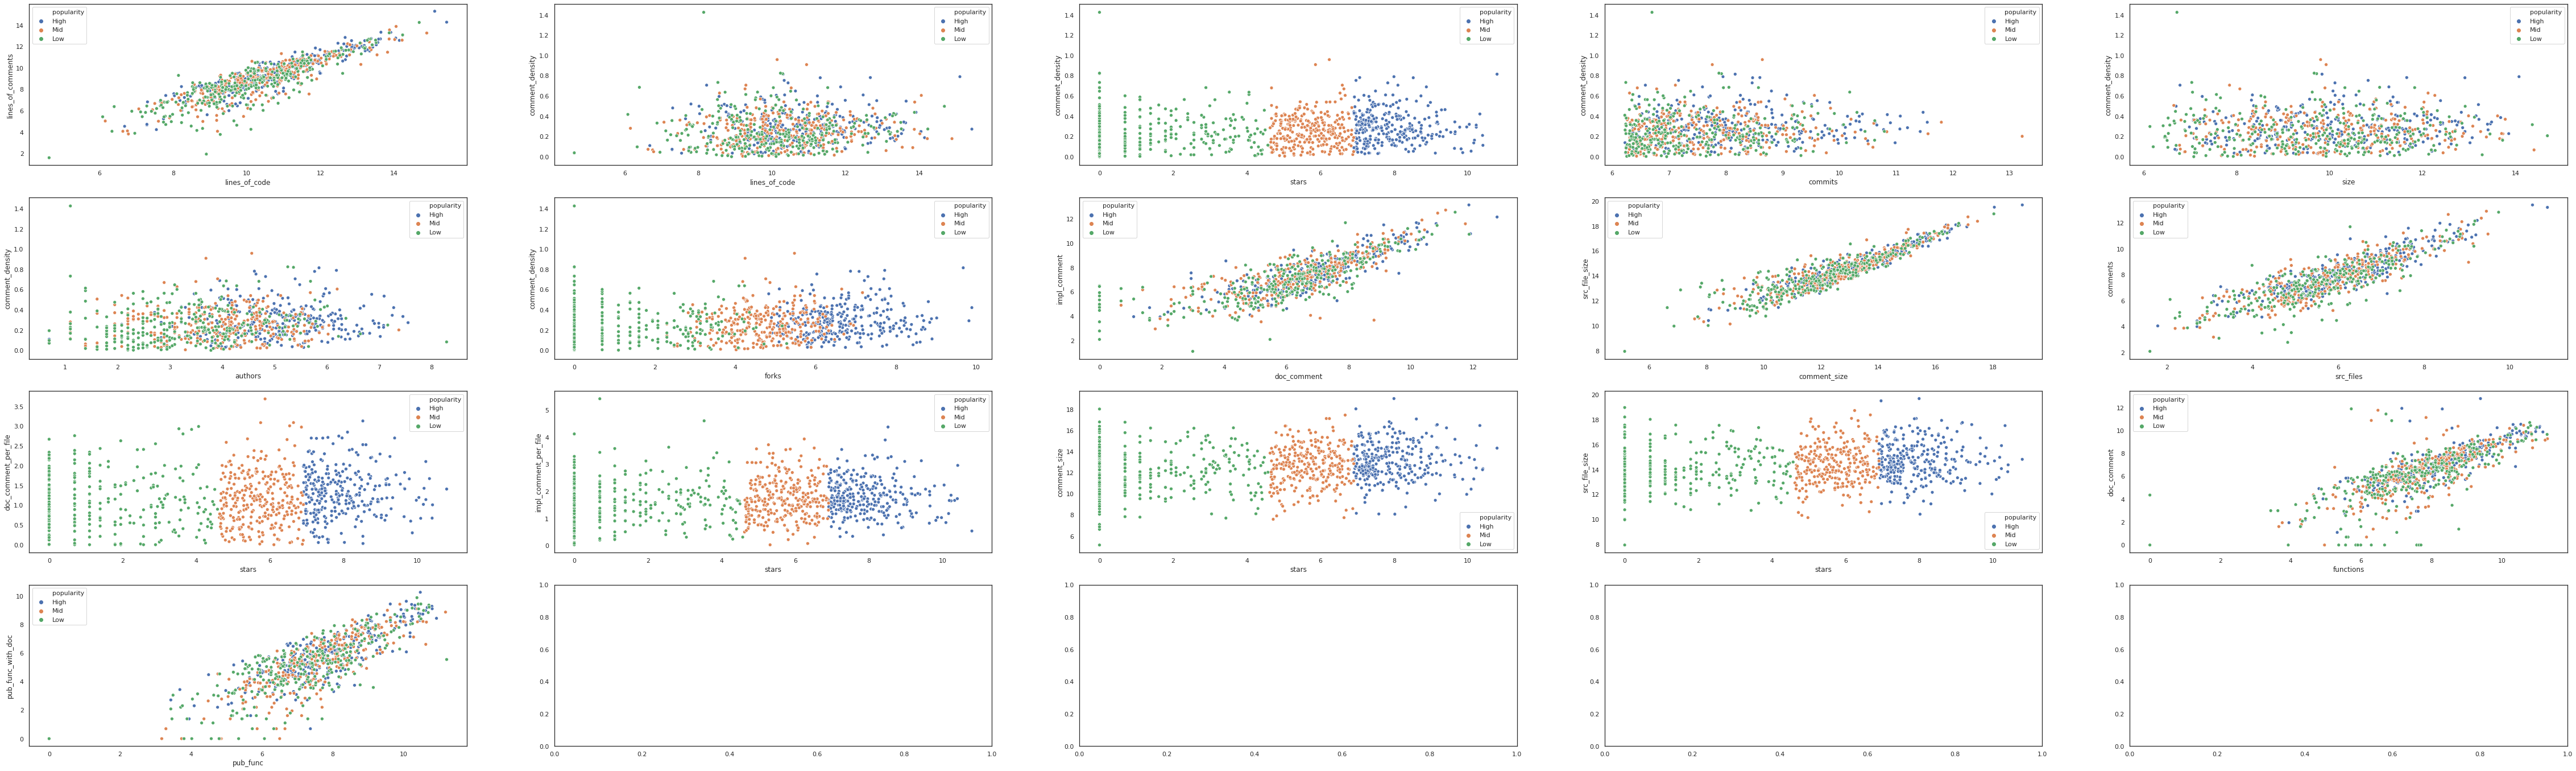

In [39]:
pairs = [('lines_of_code', 'lines_of_comments'),
        ('lines_of_code', 'comment_density'),
        ('stars', 'comment_density'),
        ('commits', 'comment_density'),
        ('size', 'comment_density'),
        ('authors', 'comment_density'),
        ('forks', 'comment_density'),
        ('doc_comment', 'impl_comment'),
        ('comment_size', 'src_file_size'),
        ('src_files', 'comments'),
        ('stars', 'doc_comment_per_file'),
        ('stars', 'impl_comment_per_file'),
        ('stars', 'comment_size'),
        ('stars', 'src_file_size'),
        ('functions', 'doc_comment'),
        ('pub_func', 'pub_func_with_doc')]
fig, axes = plt.subplots(len(pairs) // 5 + 1, 5)
fig.set_size_inches(5 * len(pairs), 6 * (len(pairs) // 5 + 1))
for i in range(0, len(pairs)):
    print(pairs[i], end=': ')
    analyze_correlation(x=np.log1p(projects[pairs[i][0]]), y=np.log1p(projects[pairs[i][1]]), types=projects['popularity'], ax=axes[i // 5][i % 5])
plt.savefig('temp/corr.pdf')

Some conclusions:
1. Popular open source projects tend to have slightly more comments in terms of both lines of comments, number of comments and length of comments. However, the overall effect is minor for many possible reasons, which calls for further analysis.
2. Popular open source projects tend to have more documentation comments, which means that either a project become popular because they are more properly documented, or popular projects need more documentation as more and more people participate in them. However, such phenomemon can not be observed on implementation comments.

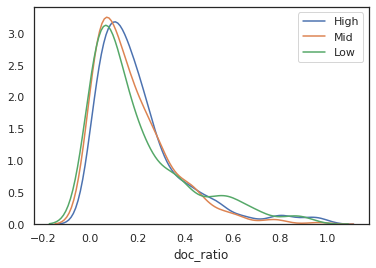

In [38]:
def plot_distribution(x):
    labels = ['High', 'Mid', 'Low']
    for label in labels:
        data = projects[projects['popularity'] == label][x]
        sns.distplot(data, hist=False, label=label)
projects['doc_ratio'] = projects['pub_func_with_doc'] / (projects['pub_func'] + 1)
plot_distribution('doc_ratio')
analyze_correlation()

## Function Level Analysis

In [17]:
import pandas as pd
import numpy as np
functions = pd.read_csv('temp/Functions.csv')
functions.head()

,name,code,visibility,has_comment,line_comment,line_count,max_indent,is_abstract,is_static,is_native,is_synchronized,child_comment
0,transform,NaN,package,True,7,1,0,False,False,False,False,0
1,getEdges,NaN,public,False,0,4,1,False,False,False,False,0
2,getPageInfo,NaN,public,False,0,4,1,False,False,False,False,0
3,toString,NaN,public,False,0,7,1,False,False,False,False,0
4,getId,NaN,public,False,0,3,1,False,False,False,False,0


In [8]:
functions.describe()

,code,line_comment,line_count,max_indent,child_comment
count,0.0,5.236240e+06,5.236240e+06,5.236240e+06,5.236240e+06
mean,NaN,1.085077e+00,1.081256e+01,1.519677e+00,4.011340e-01
std,NaN,2.857766e+00,2.542589e+01,1.039211e+00,3.159333e+00
min,NaN,0.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00
25%,NaN,0.000000e+00,4.000000e+00,1.000000e+00,0.000000e+00
50%,NaN,0.000000e+00,5.000000e+00,1.000000e+00,0.000000e+00
75%,NaN,0.000000e+00,1.100000e+01,2.000000e+00,0.000000e+00
max,NaN,4.730000e+02,3.038000e+04,2.400000e+01,1.591000e+03


In [6]:
np.mean(functions[functions['has_comment'] == True]['line_count'])

12.252888183455788

In [7]:
np.mean(functions[functions['has_comment'] == False]['line_count'])

10.468900626153

In [36]:
def print_ratio(name, a, b):
    print('{} {}/{} {}'.format(name, a, b, a/b))

print_ratio('overall', len(functions[functions['has_comment']]), len(functions))

visibility = set(functions['visibility'])
for v in visibility:
    n_comment = len(functions[(functions['visibility']==v)&(functions['has_comment']==True)])
    n_nocomment = len(functions[(functions['visibility']==v)&(functions['has_comment']==False)])
    print_ratio(v, n_comment, (n_comment + n_nocomment))

print_ratio('abstract', len(functions[(functions['is_abstract']==True)&(functions['has_comment']==True)]),
     len(functions[functions['is_abstract']==True]))
print_ratio('synchronized', len(functions[(functions['is_synchronized']==True)&(functions['has_comment']==True)]),
     len(functions[functions['is_synchronized']==True]))
print_ratio('native', len(functions[(functions['is_native']==True)&(functions['has_comment']==True)]),
     len(functions[functions['is_native']==True]))

overall 1224523/5741800 0.2132646556828869
protected 65751/362738 0.1812630603906952
package 192882/466977 0.4130438972369089
public 868598/4384359 0.1981128826357513
private 97292/527726 0.18436082360922146
abstract 22809/67087 0.3399913545098156
synchronized 10128/31759 0.31890172864384897
native 5267/41600 0.12661057692307692


1. `protected` methods are more likely to have documentation comments
2. `abstract` methods are more likely to have documentation comments
3. `synchronized` methods are more likely to have documentation comments